In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy 
from scipy import stats

In [2]:
def get_coul_vdW_lambdas(mdpfile):
    """Given an *.mdp file as input, extract the values of coul-lambdas and vdw-lambdas
    
    RETURNS
    coul_lambdas    - numpy array of coul-lambdas
    vdw_lambdas     - numpy array of vdw-lambdas
    
    NOTE: for the Moonshot2 alchemical transformations, the lambda=0 state is fully coupled, 
          and lambda=1 is fully uncoupled:
          
              couple-lambda0         = vdw-q
              couple-lambda1         = none
              
          That means that *first* the coulomb gets turned off, *then* the vdW:
          
    coul-lambdas         = 0.0 0.020 0.040 0.061 0.081 ... 0.979 1.0 1.000 1.000 1.000 1.000 ... 1.000 1.0
    vdw-lambdas          = 0.0 0.000 0.000 0.000 0.000 ... 0.000 0.0 0.020 0.040 0.061 0.081 ... 0.979 1.0
    """
        
    fin = open(mdpfile,'r')
    lines = fin.readlines()
    fin.close()
    
    coul_lambdas, vdw_lambdas = None, None
    
    for line in lines:
        if line.count('coul-lambdas'):
            coul_string = line.split('=')[1].strip()
            # print('coul_string', coul_string)
            coul_lambdas = np.array([float(s) for s in coul_string.split()])
            # print('coul_lambdas', coul_lambdas)
        elif line.count('vdw-lambdas'):
            vdw_string = line.split('=')[1].strip()
            # print('vdw_string', vdw_string)
            vdw_lambdas = np.array([float(s) for s in vdw_string.split()])

    return coul_lambdas, vdw_lambdas

In [3]:
# Let's try this for an example:
mdpfile = '../x11294_RL/RUN4/prod.mdp'
coul_lambdas, vdw_lambdas = get_coul_vdW_lambdas(mdpfile)
# print('coul_lambdas', coul_lambdas)
# print('vdw_lambdas', vdw_lambdas)

# We map each [0,1] set of values to the interval [0,2] by summing the two
lambdas = coul_lambdas + vdw_lambdas
print('lambdas', lambdas)
print('lambdas.shape', lambdas.shape)


lambdas [0.     0.0345 0.0706 0.104  0.1435 0.1873 0.2263 0.2661 0.3081 0.3468
 0.3942 0.4405 0.4846 0.5361 0.5914 0.6478 0.6984 0.7568 0.8178 0.8702
 0.9259 0.9828 1.0226 1.057  1.0762 1.0949 1.119  1.146  1.1655 1.1901
 1.2126 1.2338 1.2533 1.2711 1.2882 1.3022 1.3175 1.3335 1.3485 1.3644
 1.3852 1.4033 1.4169 1.4308 1.4486 1.4643 1.4808 1.5004 1.5138 1.5235
 1.5338 1.5469 1.5596 1.5718 1.5851 1.5975 1.6095 1.6238 1.6357 1.6447
 1.6533 1.6626 1.6725 1.6827 1.6916 1.699  1.7058 1.7127 1.7204 1.729
 1.7376 1.7458 1.7536 1.7611 1.7685 1.7761 1.7839 1.7917 1.7991 1.8062
 1.8133 1.8207 1.8283 1.8359 1.8432 1.8502 1.8572 1.8642 1.8718 1.8807
 1.892  1.9047 1.9179 1.932  1.9435 1.9536 1.9652 1.9812 2.    ]
lambdas.shape (99,)


In [4]:
def get_dhdl_data(dhdl_xvgfile, verbose=True):
    """Read and parse the information in the dhdl file.
    
    RETURNS
    time_in_ps      - time in ps (1D np.array)
    thermo_states   - thermodynamic state indices (1D np.array)
    dhdl            - delta_Uij (np.array of shape (N,K))
                      where N is snapshots and K is number of thermodynamic states
    
    NOTES
    
    time         ---> Column 0 is time in ps.                         
    thermo_index ---> Column 1 = @ s0 legend "Thermodynamic state"
                      Column 2 = @ s1 legend "Total Energy (kJ/mol)"
                      Column 3 = @ s2 legend "dH/d\\xl\\f{} fep-lambda = 0.0000"
                      Column 4 = @ s3 legend "dH/d\\xl\\f{} coul-lambda = 0.0000"
                      Column 5 = @ s4 legend "dH/d\\xl\\f{} vdw-lambda = 0.0000"
    dU_ij starts      Column 6 = @ s5 legend "\\xD\\f{}H \\xl\\f{} to (0.0000, 0.0000, 0.0000)"
                      Column 7 = @ s6 legend "\\xD\\f{}H \\xl\f{} to (0.0000, 0.0200, 0.0000)"
                      Column 8 = @ s7 legend "\\xD\\f{}H \\xl\\f{} to (0.0000, 0.0400, 0.0000)"
    """
    
    
    import os
    assert os.path.exists(dhdl_xvgfile)
    
    # Read and parse the file
    fin = open(dhdl_xvgfile,'r')
    lines = fin.readlines()
    fin.close()
    
    dhdl_column_start = None
    # Read to headers to find which column starts the dhdl data
    for line in lines:
        # Looking for line like this: "@ s5 legend "\xD\f{}H \xl\f{} to (0.0000, 0.0000, 0.0000)"
        if line.count('"\\xD\\f{}H') > 0:
            dhdl_column_start = int(line.split(' ')[1].replace('s','')) + 1
            break
    if verbose:
        print('dhdl data starts at column:', dhdl_column_start)

    # Get rid of all the header lines
    i = 0
    while i < len(lines):
        if (lines[i][0] == '#') or (lines[i][0] == '@'):
            lines.pop(i)
        else:
            i+=1
    
    # find the correct number of entries from the first line
    ncols = len(lines[0].strip().split())
    print(lines[0])
    print('ncols', ncols)
    
    time_in_ps, dhdl, thermo_states = [], [], []
    for line in lines:
        line_data_list = [float(s) for s in line.strip().split()] 
            
        # Skip line if it doesn't have the correct number of entries
        # (sometimes the I/O gets cutoff when writing the dhdl.xvg in it corrupts the data)
        if len(line_data_list) == ncols:
            time_in_ps.append(line_data_list[0])
            thermo_states.append(line_data_list[1])
            dhdl.append(line_data_list[dhdl_column_start:])
            
    time_in_ps = np.array(time_in_ps)
    dhdl = np.array(dhdl)
    thermo_states = np.array(thermo_states)
    
    print('time_in_ps.shape', time_in_ps.shape)
    print('dhdl.shape=', dhdl.shape)
    print('thermo_states=', thermo_states)

    return time_in_ps, thermo_states, dhdl


###############
    
    
dhdl_xvgfile = '../x11294_RL/RUN4/dhdl.xvg'
time_in_ps, thermo_states, dhdl = get_dhdl_data(dhdl_xvgfile)
print('time_in_ps', time_in_ps)
print('thermo_states', thermo_states)
print('dhdl', dhdl)


dhdl data starts at column: 7
0.0000    0 -458523.19 0.0000000 286.95279 100.08384 0.0000000 0.0000000 5.7391623 11.478236 17.504277 23.243259 29.269304 35.008197 40.747389 46.773352 52.512502 58.538395 64.277638 70.016784 76.042635 81.781469 87.807611 93.546595 99.285676 105.31186 111.05084 117.07682 122.81580 128.55490 134.58099 140.32003 146.34602 152.08506 158.11107 163.85002 169.58913 175.61525 181.35423 187.38023 193.11927 198.85834 204.88432 210.62345 216.64943 222.38842 228.12755 234.15354 239.89263 245.91858 251.65767 257.39673 263.42272 269.16179 275.18778 280.92683 286.95285 286.95285 289.05312 291.34026 293.92678 296.55282 299.46755 302.38190 305.42128 308.73700 312.00458 315.54209 319.00530 322.55370 326.36468 330.06935 334.03255 337.87177 341.76972 345.92124 349.92699 354.18363 358.28229 362.42145 366.80803 371.02147 375.48032 379.75754 384.27837 388.61016 392.96561 397.56229 401.96071 406.59890 411.03366 415.48395 420.17203 424.65022 429.36494 433.86609 438.37687 443.122

Next, we estimate the sigmas from the dhdl data

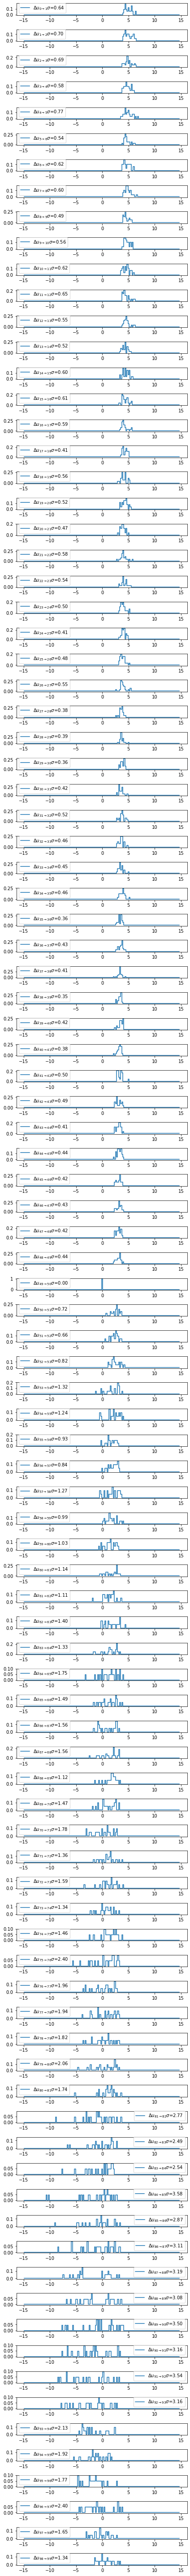

In [6]:
def estimate_sigmas(dhdl, thermo_states, plot_data=True):
    """Using as input the Delta_U_ij energies from the dhdl array, 
    estimate the standard deviations P(U_{i-->i+1}) for neighboring ensembles.
    
    RETURNS
    sigmas   - a list of standard deviations P(U_{i-->i+1}).
    """
    
    nlambdas = dhdl.shape[1]
    
    if plot_data:
        plt.figure(figsize=(6, 80))

    Delta_uij_values = []     
    sigmas = []
       
    for j in range(nlambdas-1):
    
        ##transitions from state 0 to 1 or 1 to 2, or 2 to 3 .... 
        Ind_i = (thermo_states == j)
        delta_u_ij = dhdl[Ind_i, j+1]       ##only for neighbored ensembles

        #Delta_uij_values.append(delta_u_ij)

        mu, sigma = scipy.stats.norm.fit(delta_u_ij)
        #print (mu, sigma)
        sigmas.append(sigma)

        delta_u_bins = np.arange(-15., 15., 0.2)
        counts, bin_edges = np.histogram(delta_u_ij, bins=delta_u_bins)
        counts = counts/counts.sum() # normalize
        bin_centers = (bin_edges[0:-1] + bin_edges[1:])/2.0

        if plot_data:
            plt.subplot(nlambdas-1, 1, j+1)
            plt.step(bin_centers, counts, label='$\Delta u_{%d \\rightarrow %d} \sigma$=%.2f'%(j,j+1,sigma))
            #plt.xlabel('$\Delta u_{%d \\rightarrow %d}$'%(j, j+1))
            plt.legend(loc='best')
        
    if plot_data:
        plt.tight_layout()
        plt.show()

    return sigmas

##################

sigmas = estimate_sigmas(dhdl, thermo_states, plot_data=True)

In [7]:
# For *THIS* particular data set we can see there is a problem:
# The i=49 --> i+1 = 50 lambdas are the same, resulting in a sigma of zero for that transition
# Let's remove it

remove_index = 49
# print('sigmas', sigmas)
sigmas.pop(remove_index)
# print('FIXED sigmas', sigmas)

print('lambdas',lambdas)
print('lambdas.shape',lambdas.shape)
lambdas_list = lambdas.tolist()
lambdas_list.pop(remove_index)
lambdas = np.array(lambdas_list)
print('FIXED lambdas',lambdas)
print('FIXED lambdas.shape',lambdas.shape)

lambdas [0.     0.0345 0.0706 0.104  0.1435 0.1873 0.2263 0.2661 0.3081 0.3468
 0.3942 0.4405 0.4846 0.5361 0.5914 0.6478 0.6984 0.7568 0.8178 0.8702
 0.9259 0.9828 1.0226 1.057  1.0762 1.0949 1.119  1.146  1.1655 1.1901
 1.2126 1.2338 1.2533 1.2711 1.2882 1.3022 1.3175 1.3335 1.3485 1.3644
 1.3852 1.4033 1.4169 1.4308 1.4486 1.4643 1.4808 1.5004 1.5138 1.5235
 1.5338 1.5469 1.5596 1.5718 1.5851 1.5975 1.6095 1.6238 1.6357 1.6447
 1.6533 1.6626 1.6725 1.6827 1.6916 1.699  1.7058 1.7127 1.7204 1.729
 1.7376 1.7458 1.7536 1.7611 1.7685 1.7761 1.7839 1.7917 1.7991 1.8062
 1.8133 1.8207 1.8283 1.8359 1.8432 1.8502 1.8572 1.8642 1.8718 1.8807
 1.892  1.9047 1.9179 1.932  1.9435 1.9536 1.9652 1.9812 2.    ]
lambdas.shape (99,)
FIXED lambdas [0.     0.0345 0.0706 0.104  0.1435 0.1873 0.2263 0.2661 0.3081 0.3468
 0.3942 0.4405 0.4846 0.5361 0.5914 0.6478 0.6984 0.7568 0.8178 0.8702
 0.9259 0.9828 1.0226 1.057  1.0762 1.0949 1.119  1.146  1.1655 1.1901
 1.2126 1.2338 1.2533 1.2711 1.2882 1.3022

## Lambda optimization

In [8]:
dx = sigmas                 #according to Vince's equation (VAV: k is set to 1)
#print (dx, len(dx))

x_values = np.cumsum(dx)    # convert to a list of x values
x_values = np.array(np.concatenate([[0], x_values]))    # add a zero corresponding to lambda0 = 0.0
## VAV: This zero needs to be included.  Why was this left out before?
print('x_values', x_values)

x_values [  0.           0.64147943   1.3397324    2.02565011   2.61015355
   3.37952748   3.920564     4.54277383   5.14475716   5.62983075
   6.19319793   6.81200465   7.45892938   8.0087686    8.52790892
   9.12683131   9.73199707  10.32065198  10.73420929  11.29791693
  11.81973832  12.28624077  12.86462524  13.40611376  13.90249108
  14.30783289  14.79034999  15.34340839  15.72060081  16.11004178
  16.46859197  16.88666238  17.408746    17.86822684  18.31813934
  18.78013797  19.14414262  19.57150956  19.97971816  20.32836871
  20.74419781  21.12531051  21.62218551  22.10829407  22.5157951
  22.95684287  23.38023112  23.80787623  24.23228905  24.6764266
  25.3937657   26.05233787  26.87012401  28.18556183  29.423551
  30.3487275   31.19022357  32.45762311  33.45079235  34.48364795
  35.6260253   36.73866565  38.14353     39.47461476  41.22844775
  42.71703249  44.27836528  45.84274412  46.96363485  48.43835801
  50.22335693  51.58553607  53.18041913  54.51569383  55.97884563
  58.

ValueError: x and y must have same first dimension, but have shapes (98,) and (99,)

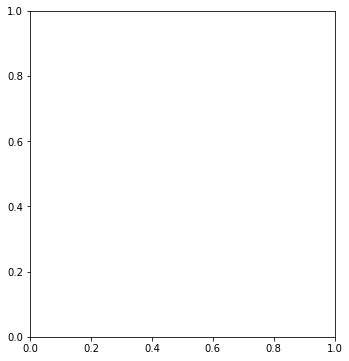

In [9]:
from scipy.interpolate import UnivariateSpline
#from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
plt.figure(figsize=(12,6))

lambda_values = lambdas #not inclduing the first one, lambda_0 

x_observed = lambda_values      #not inclduing the first one, lambda_0
y_observed = x_values

plt.subplot(1,2,1)
plt.plot(x_observed, y_observed, 'ro', label = 'data')
#plt.semilogy(x_observed, y_observed, 'ro', label = 'data')

#y_spl = CubicSpline(x_observed, y_observed)#, s=0,k=4)  
y_spl = UnivariateSpline(x_observed, y_observed, s=0, k=3)  
x_range = np.linspace(x_observed[0], x_observed[-1], 1000)
plt.plot(x_range, y_spl(x_range), label="spline")   # for UnivariateSpline
## plt.plot(x_observed, y_spl(x_observed), label="spline") # for CubicSpline
plt.legend()
plt.xlabel('lambda')
plt.ylabel('x values')

plt.subplot(1,2, 2)   #derivative plot
y_spl_1d = y_spl.derivative(n=1)    #n=1 , means the first order derivative
#print (y_spl_1d(x_observed))
# y_spl_1d = y_spl(x_observed, 1)  # first derivative of Cubic spline


plt.plot(x_range, y_spl_1d(x_range), '-')
plt.plot(x_observed, y_spl_1d(x_observed), '.')
plt.ylabel('dx/dlambda')

#plt.plot(x_observed, y_spl_1d, '.-', label='derivative')
plt.legend()
plt.xlabel('lambda')

lambda_values [0.    0.02  0.04  0.061 0.081 0.102 0.122 0.142 0.163 0.183 0.204 0.224
 0.244 0.265 0.285 0.306 0.326 0.346 0.367 0.387 0.408 0.428 0.448 0.469
 0.489 0.51  0.53  0.551 0.571 0.591 0.612 0.632 0.653 0.673 0.693 0.714
 0.734 0.755 0.775 0.795 0.816 0.836 0.857 0.877 0.897 0.918 0.938 0.959
 0.979 1.    1.02  1.04  1.061 1.081 1.102 1.122 1.142 1.163 1.183 1.204
 1.224 1.244 1.265 1.285 1.306 1.326 1.346 1.367 1.387 1.408 1.428 1.448
 1.469 1.489 1.51  1.53  1.551 1.571 1.591 1.612 1.632 1.653 1.673 1.693
 1.714 1.734 1.755 1.775 1.795 1.816 1.836 1.857 1.877 1.897 1.918 1.938
 1.959 1.979 2.   ]
step 0 del_lambdas 1.0839097819523561e-05
step 250 del_lambdas 2.0942398389709528e-05
step 500 del_lambdas 2.0390167753343734e-05
step 750 del_lambdas 2.358342472554132e-05
step 1000 del_lambdas 2.5563543488420774e-05
step 1250 del_lambdas 2.5944863422389562e-05
step 1500 del_lambdas 2.523278448159805e-05
step 1750 del_lambdas 2.5120393226300642e-05
step 2000 del_lambdas 2.404725

step 44750 del_lambdas 7.528583971669088e-06
step 45000 del_lambdas 8.67301402798897e-06
step 45250 del_lambdas 7.263066038365841e-06
step 45500 del_lambdas 8.613798141938812e-06
step 45750 del_lambdas 7.322694818284645e-06
step 46000 del_lambdas 8.66084799255505e-06
step 46250 del_lambdas 7.228388060978109e-06
step 46500 del_lambdas 8.720661942575924e-06
step 46750 del_lambdas 7.153607659267803e-06
step 47000 del_lambdas 8.660514431636089e-06
step 47250 del_lambdas 7.148756235582954e-06
step 47500 del_lambdas 8.737605213581795e-06
step 47750 del_lambdas 6.941663725282539e-06
step 48000 del_lambdas 8.560445806791364e-06
step 48250 del_lambdas 6.959493412153677e-06
step 48500 del_lambdas 8.488682523559899e-06
step 48750 del_lambdas 6.9054712149445054e-06
step 49000 del_lambdas 8.599968270687242e-06
step 49250 del_lambdas 6.816308040788981e-06
step 49500 del_lambdas 8.277667773179728e-06
step 49750 del_lambdas 6.984001448754769e-06
step 50000 del_lambdas 8.462459688206597e-06
step 50250 

step 90500 del_lambdas 5.825260070248363e-06
step 90750 del_lambdas 5.774895548027487e-06
step 91000 del_lambdas 5.822827382123416e-06
step 91250 del_lambdas 5.770679086351955e-06
step 91500 del_lambdas 5.8035283873146145e-06
step 91750 del_lambdas 5.75476062838288e-06
step 92000 del_lambdas 5.802338721305391e-06
step 92250 del_lambdas 5.749971665086954e-06
step 92500 del_lambdas 5.783496900474416e-06
step 92750 del_lambdas 5.733357310793376e-06
step 93000 del_lambdas 5.781089263005114e-06
step 93250 del_lambdas 5.728853029113063e-06
step 93500 del_lambdas 5.762349075931806e-06
step 93750 del_lambdas 5.712736572703112e-06
step 94000 del_lambdas 5.758252538422971e-06
step 94250 del_lambdas 5.707470209000732e-06
step 94500 del_lambdas 5.740219950114459e-06
step 94750 del_lambdas 5.6926823709714984e-06
step 95000 del_lambdas 5.738141491059691e-06
step 95250 del_lambdas 5.687983335208936e-06
step 95500 del_lambdas 5.7186231176657955e-06
step 95750 del_lambdas 5.672123371000902e-06
step 960

Text(0, 0.5, 'x values')

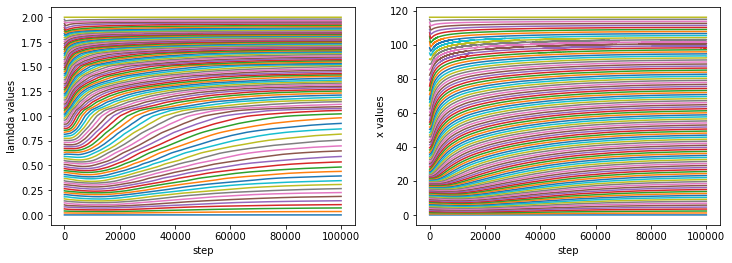

In [40]:
# Let's try a steepest descent algorithm like the kind I wrote up in "math-gradient-descent-2021-05-07.pdf"

# run the algorithm some fixed number of steps, or until some tolerance is reached
nsteps = 100000
tol = 1e-7  # stop if the lambdas dont change within this tolerance

alpha = 1e-5  # gradient descent step size
max_del_lambda = 0.0001   # the minimization step limited to this as a maximum change

VERBOSE = False
print_every = 250

nlambdas = len(lambda_values)
print('lambda_values', lambda_values)
old_lambdas = np.array(lambda_values)
traj_lambdas = np.zeros( (nlambdas,nsteps) )
for step in range(nsteps):

    # store the trajectory of lambdas
    traj_lambdas[:,step] = old_lambdas
    if VERBOSE:
        print('step', step, old_lambdas)
    
    # perform a steepest descent step
    new_lambdas = np.zeros( old_lambdas.shape )
    del_lambdas = np.zeros( old_lambdas.shape )
    del_lambdas[0] = 0.0   # fix the \lambda = 0 endpoint
    del_lambdas[nlambdas-1] = 0.0  # fix the \lambda = 1 endpoint
    
    if False:  # do in a loop (SLOW!) 
        for i in range(1, (nlambdas-1)):
            del_lambdas[i] = -1.0*alpha*2.0*y_spl_1d(old_lambdas[i])*( 2.0*y_spl(old_lambdas[i]) - y_spl(old_lambdas[i-1]) - y_spl(old_lambdas[i+1]))
    else:   # do as a vector operation (FAST!) 
        y_all = y_spl(old_lambdas)
        yh, yi, yj = y_all[0:nlambdas-2], y_all[1:nlambdas-1], y_all[2:nlambdas] 
        del_lambdas[1:nlambdas-1] = -1.0*alpha*2.0*y_spl_1d(old_lambdas[1:nlambdas-1])*( 2.0*yi - yh - yj)
    if abs(np.max(del_lambdas)) > max_del_lambda:
        del_lambdas[1:nlambdas-1] = del_lambdas[1:nlambdas-1]*max_del_lambda/np.max(del_lambdas)
    new_lambdas = old_lambdas + del_lambdas
    
    # record the average change in the lambdas 
    del_lambdas = np.abs(old_lambdas - new_lambdas).mean()
    if step % print_every == 0:
        print('step', step, 'del_lambdas', del_lambdas)
    if del_lambdas < tol:
        print('Tolerance has been reached: del_lambdas =', del_lambdas, '< tol =', tol)
        break
        
    old_lambdas = new_lambdas
    
# Plot the results
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
for i in range(nlambdas):
    plt.plot(range(step), traj_lambdas[i,0:step], '-')
plt.xlabel('step')
plt.ylabel('lambda values')

plt.subplot(1,2,2)
for i in range(nlambdas):
    plt.plot(range(step), y_spl(traj_lambdas[i,0:step]), '-')
plt.xlabel('step')
plt.ylabel('x values')

new_lambdas [0.         0.03450459 0.07059936 0.10401702 0.14351839 0.18733839
 0.22629346 0.26614114 0.30807142 0.34680614 0.39419432 0.44050075
 0.48456599 0.53610616 0.59137981 0.6477614  0.69843717 0.756753
 0.8177663  0.8702011  0.92588027 0.98283651 1.02258595 1.05701253
 1.07617434 1.09488758 1.1189661  1.1459666  1.16545335 1.19010974
 1.21258925 1.23381094 1.25327211 1.27108653 1.28817863 1.30218683
 1.31754446 1.33354749 1.3485352  1.36437433 1.38519099 1.40327645
 1.41688212 1.43076613 1.44857528 1.4642521  1.48082697 1.50044136
 1.51384319 1.52347359 1.53377705 1.54686275 1.55959821 1.57182795
 1.58507564 1.59746065 1.60952383 1.6238192  1.63568696 1.64472622
 1.6533211  1.66255838 1.67252785 1.68267436 1.69161197 1.69903508
 1.70583608 1.71274181 1.72044191 1.72896146 1.73756153 1.74575027
 1.75356826 1.76109077 1.76851614 1.77608073 1.78390598 1.79168016
 1.79909871 1.80619673 1.81332437 1.82068841 1.82834507 1.83586767
 1.84319643 1.85015863 1.85722401 1.86420355 1.87178

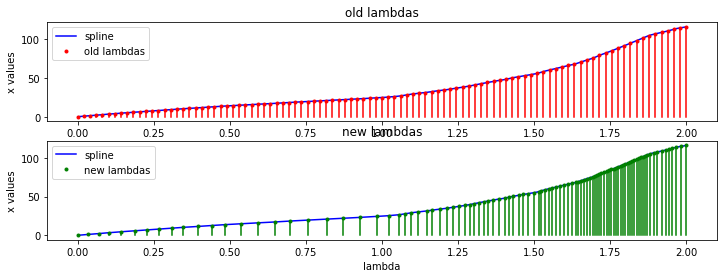

In [41]:
plt.figure(figsize=(12,4))

plt.subplot(2,1,1)
plt.plot(x_range, y_spl(x_range), 'b-', label="spline")
plt.plot(lambda_values, y_spl(np.array(lambda_values)), 'r.', label="old lambdas")
for value in lambda_values:
    plt.plot([value, value], [0, y_spl(value)], 'r-')
plt.legend()
plt.xlabel('lambda')
plt.ylabel('x values')
plt.title('old lambdas')

plt.subplot(2,1,2)
plt.plot(x_range, y_spl(x_range), 'b-', label="spline")
plt.plot(new_lambdas, y_spl(new_lambdas), 'g.', label="new lambdas")
for value in new_lambdas:
    plt.plot([value, value], [0, y_spl(value)], 'g-')
plt.legend()
plt.xlabel('lambda')
plt.ylabel('x values')
plt.title('new lambdas')

print('new_lambdas', new_lambdas)

In [42]:
# Finally, we transform the [0,2] coul+vdW interval back to separate coul_lambdas and vdw_lambdas

new_coul_lambdas = np.minimum(new_lambdas, np.ones(new_lambdas.shape))
new_vdw_lambdas  = np.maximum(new_lambdas, np.ones(new_lambdas.shape)) - 1.0

#print('new_coul_lambdas',new_coul_lambdas)
#print('new_vdw_lambdas',new_vdw_lambdas)

# print out the new lambdas as if they were in an mdp file
outstring = 'coul-lambdas    = ' + " ".join(['%1.4f'%lam for lam in new_coul_lambdas])
print(outstring)

outstring = 'vdw-lambdas     = ' + " ".join(['%1.4f'%lam for lam in new_vdw_lambdas])
print(outstring)


coul-lambdas    = 0.0000 0.0345 0.0706 0.1040 0.1435 0.1873 0.2263 0.2661 0.3081 0.3468 0.3942 0.4405 0.4846 0.5361 0.5914 0.6478 0.6984 0.7568 0.8178 0.8702 0.9259 0.9828 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000 1.0000
vdw-lambdas     = 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0226 0.0570 0.0762 0.0949 0.1190 0.1460 0.1655 0.1901 0.2126 0.2338 0.2533 0.2711 0.2882 0.3022 0.3175 0.3335 0.348